In [1]:
import torchvision
import os
from google.colab.patches import cv2_imshow
import numpy as np
import math
import pickle
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),  # Resize to 224x224 to match MobileNet's input size
    torchvision.transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [4]:
os.mkdir('/content/dataset/')
os.mkdir('/content/dataset/train/')
os.mkdir('/content/dataset/test/')
train_dataset = torchvision.datasets.CIFAR100(root='/content/dataset/train/', download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='/content/dataset/test/', download=True, transform=transform)

100%|██████████| 169001437/169001437 [00:12<00:00, 13224759.94it/s]


Extracting /content/dataset/train/cifar-100-python.tar.gz to /content/dataset/train/


100%|██████████| 169001437/169001437 [00:24<00:00, 6967877.42it/s]


Extracting /content/dataset/test/cifar-100-python.tar.gz to /content/dataset/test/


In [5]:
#@title CIFAR100 Classes & Superclasses

import json

# Define the classes and superclasses
cifar100_classes = [
    # Superclass: Aquatic Mammals
    {"class": "beaver", "superclass": "aquatic mammals"},
    {"class": "dolphin", "superclass": "aquatic mammals"},
    {"class": "otter", "superclass": "aquatic mammals"},
    {"class": "seal", "superclass": "aquatic mammals"},
    {"class": "whale", "superclass": "aquatic mammals"},

    # Superclass: Fish
    {"class": "aquarium fish", "superclass": "fish"},
    {"class": "flatfish", "superclass": "fish"},
    {"class": "ray", "superclass": "fish"},
    {"class": "shark", "superclass": "fish"},
    {"class": "trout", "superclass": "fish"},

    # Superclass: Flowers
    {"class": "orchid", "superclass": "flowers"},
    {"class": "poppy", "superclass": "flowers"},
    {"class": "rose", "superclass": "flowers"},
    {"class": "sunflower", "superclass": "flowers"},
    {"class": "tulip", "superclass": "flowers"},

    # Superclass: Food Containers
    {"class": "bottle", "superclass": "food containers"},
    {"class": "bowl", "superclass": "food containers"},
    {"class": "can", "superclass": "food containers"},
    {"class": "cup", "superclass": "food containers"},
    {"class": "plate", "superclass": "food containers"},

    # Superclass: Fruits and Vegetables
    {"class": "apple", "superclass": "fruits and vegetables"},
    {"class": "mushroom", "superclass": "fruits and vegetables"},
    {"class": "orange", "superclass": "fruits and vegetables"},
    {"class": "pear", "superclass": "fruits and vegetables"},
    {"class": "sweet pepper", "superclass": "fruits and vegetables"},

    # Superclass: Household Electrical Devices
    {"class": "clock", "superclass": "household electrical devices"},
    {"class": "keyboard", "superclass": "household electrical devices"},
    {"class": "lamp", "superclass": "household electrical devices"},
    {"class": "telephone", "superclass": "household electrical devices"},
    {"class": "television", "superclass": "household electrical devices"},

    # Superclass: Household Furniture
    {"class": "bed", "superclass": "household furniture"},
    {"class": "chair", "superclass": "household furniture"},
    {"class": "couch", "superclass": "household furniture"},
    {"class": "table", "superclass": "household furniture"},
    {"class": "wardrobe", "superclass": "household furniture"},

    # Superclass: Insects
    {"class": "bee", "superclass": "insects"},
    {"class": "beetle", "superclass": "insects"},
    {"class": "butterfly", "superclass": "insects"},
    {"class": "caterpillar", "superclass": "insects"},
    {"class": "cockroach", "superclass": "insects"},

    # Superclass: Large Carnivores
    {"class": "bear", "superclass": "large carnivores"},
    {"class": "leopard", "superclass": "large carnivores"},
    {"class": "lion", "superclass": "large carnivores"},
    {"class": "tiger", "superclass": "large carnivores"},
    {"class": "wolf", "superclass": "large carnivores"},

    # Superclass: Large Man-made Outdoor Things
    {"class": "bridge", "superclass": "large man-made outdoor things"},
    {"class": "castle", "superclass": "large man-made outdoor things"},
    {"class": "house", "superclass": "large man-made outdoor things"},
    {"class": "road", "superclass": "large man-made outdoor things"},
    {"class": "skyscraper", "superclass": "large man-made outdoor things"},

    # Superclass: Large Natural Outdoor Scenes
    {"class": "cloud", "superclass": "large natural outdoor scenes"},
    {"class": "forest", "superclass": "large natural outdoor scenes"},
    {"class": "mountain", "superclass": "large natural outdoor scenes"},
    {"class": "plain", "superclass": "large natural outdoor scenes"},
    {"class": "sea", "superclass": "large natural outdoor scenes"},

    # Superclass: Large Omnivores and Herbivores
    {"class": "camel", "superclass": "large omnivores and herbivores"},
    {"class": "cattle", "superclass": "large omnivores and herbivores"},
    {"class": "chimpanzee", "superclass": "large omnivores and herbivores"},
    {"class": "elephant", "superclass": "large omnivores and herbivores"},
    {"class": "kangaroo", "superclass": "large omnivores and herbivores"},

    # Superclass: Medium-sized Mammals
    {"class": "fox", "superclass": "medium-sized mammals"},
    {"class": "porcupine", "superclass": "medium-sized mammals"},
    {"class": "possum", "superclass": "medium-sized mammals"},
    {"class": "raccoon", "superclass": "medium-sized mammals"},
    {"class": "skunk", "superclass": "medium-sized mammals"},

    # Superclass: Non-insect Invertebrates
    {"class": "crab", "superclass": "non-insect invertebrates"},
    {"class": "lobster", "superclass": "non-insect invertebrates"},
    {"class": "snail", "superclass": "non-insect invertebrates"},
    {"class": "spider", "superclass": "non-insect invertebrates"},
    {"class": "worm", "superclass": "non-insect invertebrates"},

    # Superclass: People
    {"class": "baby", "superclass": "people"},
    {"class": "boy", "superclass": "people"},
    {"class": "girl", "superclass": "people"},
    {"class": "man", "superclass": "people"},
    {"class": "woman", "superclass": "people"},

    # Superclass: Reptiles
    {"class": "crocodile", "superclass": "reptiles"},
    {"class": "dinosaur", "superclass": "reptiles"},
    {"class": "lizard", "superclass": "reptiles"},
    {"class": "snake", "superclass": "reptiles"},
    {"class": "turtle", "superclass": "reptiles"},

    # Superclass: Small Mammals
    {"class": "hamster", "superclass": "small mammals"},
    {"class": "mouse", "superclass": "small mammals"},
    {"class": "rabbit", "superclass": "small mammals"},
    {"class": "shrew", "superclass": "small mammals"},
    {"class": "squirrel", "superclass": "small mammals"},

    # Superclass: Trees
    {"class": "maple tree", "superclass": "trees"},
    {"class": "oak tree", "superclass": "trees"},
    {"class": "palm tree", "superclass": "trees"},
    {"class": "pine tree", "superclass": "trees"},
    {"class": "willow tree", "superclass": "trees"},

    # Superclass: Vehicles 1
    {"class": "bicycle", "superclass": "vehicles 1"},
    {"class": "bus", "superclass": "vehicles 1"},
    {"class": "motorcycle", "superclass": "vehicles 1"},
    {"class": "pickup truck", "superclass": "vehicles 1"},
    {"class": "train", "superclass": "vehicles 1"},

    # Superclass: Vehicles 2
    {"class": "lawn mower", "superclass": "vehicles 2"},
    {"class": "rocket", "superclass": "vehicles 2"},
    {"class": "streetcar", "superclass": "vehicles 2"},
    {"class": "tank", "superclass": "vehicles 2"},
    {"class": "tractor", "superclass": "vehicles 2"},
]

# Write to JSON file
with open('cifar100_classes.json', 'w') as json_file:
    json.dump(cifar100_classes, json_file, indent=4)

superclasses = [
    "aquatic mammals",          # 1-5
    "fish",                     # 6-10
    "flowers",                  # 11-15
    "food containers",          # 16-20
    "fruits and vegetables",    # 21-25
    "household electrical devices",  # 26-30
    "household furniture",      # 31-35
    "insects",                  # 36-40
    "large carnivores",         # 41-45
    "large man-made outdoor things", # 46-50
    "large natural outdoor scenes",  # 51-55
    "large omnivores and herbivores",# 56-60
    "medium-sized mammals",     # 61-65
    "non-insect invertebrates", # 66-70
    "people",                   # 71-75
    "reptiles",                 # 76-80
    "small mammals",            # 81-85
    "trees",                    # 86-90
    "vehicles 1",               # 91-95
    "vehicles 2"                # 96-100
]

classes = [
    # Aquatic Mammals
    "beaver", "dolphin", "otter", "seal", "whale",

    # Fish
    "aquarium fish", "flatfish", "ray", "shark", "trout",

    # Flowers
    "orchid", "poppy", "rose", "sunflower", "tulip",

    # Food Containers
    "bottle", "bowl", "can", "cup", "plate",

    # Fruits and Vegetables
    "apple", "mushroom", "orange", "pear", "sweet pepper",

    # Household Electrical Devices
    "clock", "keyboard", "lamp", "telephone", "television",

    # Household Furniture
    "bed", "chair", "couch", "table", "wardrobe",

    # Insects
    "bee", "beetle", "butterfly", "caterpillar", "cockroach",

    # Large Carnivores
    "bear", "leopard", "lion", "tiger", "wolf",

    # Large Man-made Outdoor Things
    "bridge", "castle", "house", "road", "skyscraper",

    # Large Natural Outdoor Scenes
    "cloud", "forest", "mountain", "plain", "sea",

    # Large Omnivores and Herbivores
    "camel", "cattle", "chimpanzee", "elephant", "kangaroo",

    # Medium-sized Mammals
    "fox", "porcupine", "possum", "raccoon", "skunk",

    # Non-insect Invertebrates
    "crab", "lobster", "snail", "spider", "worm",

    # People
    "baby", "boy", "girl", "man", "woman",

    # Reptiles
    "crocodile", "dinosaur", "lizard", "snake", "turtle",

    # Small Mammals
    "hamster", "mouse", "rabbit", "shrew", "squirrel",

    # Trees
    "maple tree", "oak tree", "palm tree", "pine tree", "willow tree",

    # Vehicles 1
    "bicycle", "bus", "motorcycle", "pickup truck", "train",

    # Vehicles 2
    "lawn mower", "rocket", "streetcar", "tank", "tractor"
]

In [6]:
file_path = '/content/dataset/test/cifar-100-python/meta'

# Unpickle the file
with open(file_path, 'rb') as file:
    data = pickle.load(file)

alphabetical_to_original_label = {}

for label_id, label in enumerate(data['fine_label_names']):
  label = label.replace('_', ' ')
  new_index = classes.index(label)
  superclass = cifar100_classes[new_index]['superclass']
  new_superclass_index = superclasses.index(superclass)
  # print(label, new_index, new_superclass_index)
  alphabetical_to_original_label[label_id] = {'index': new_index, 'class':classes[new_index], 'super_index':new_superclass_index, 'superclass': superclass}

print(alphabetical_to_original_label)

superclass_and_class_to_hierarchic_label = {}

for key in alphabetical_to_original_label:
  info = alphabetical_to_original_label[key]
  superclass = info['superclass']
  if superclass not in superclass_and_class_to_hierarchic_label:
    hierarchic_label = 0
    superclass_and_class_to_hierarchic_label[superclass] = 0
  else:
    hierarchic_label = superclass_and_class_to_hierarchic_label[superclass] + 1
    superclass_and_class_to_hierarchic_label[superclass] = hierarchic_label
  info['hierarchic_index'] = hierarchic_label
  alphabetical_to_original_label[key] = info

print(alphabetical_to_original_label)

{0: {'index': 20, 'class': 'apple', 'super_index': 4, 'superclass': 'fruits and vegetables'}, 1: {'index': 5, 'class': 'aquarium fish', 'super_index': 1, 'superclass': 'fish'}, 2: {'index': 70, 'class': 'baby', 'super_index': 14, 'superclass': 'people'}, 3: {'index': 40, 'class': 'bear', 'super_index': 8, 'superclass': 'large carnivores'}, 4: {'index': 0, 'class': 'beaver', 'super_index': 0, 'superclass': 'aquatic mammals'}, 5: {'index': 30, 'class': 'bed', 'super_index': 6, 'superclass': 'household furniture'}, 6: {'index': 35, 'class': 'bee', 'super_index': 7, 'superclass': 'insects'}, 7: {'index': 36, 'class': 'beetle', 'super_index': 7, 'superclass': 'insects'}, 8: {'index': 90, 'class': 'bicycle', 'super_index': 18, 'superclass': 'vehicles 1'}, 9: {'index': 15, 'class': 'bottle', 'super_index': 3, 'superclass': 'food containers'}, 10: {'index': 16, 'class': 'bowl', 'super_index': 3, 'superclass': 'food containers'}, 11: {'index': 71, 'class': 'boy', 'super_index': 14, 'superclass'

In [7]:
for td_id, td in enumerate(train_dataset):
  pil_img = td[0]
  numpy_img = np.clip(pil_img.permute(1, 2, 0).numpy()[:, :, ::-1] * 255, 0, 255)
  class_label = td[1]
  print(numpy_img.shape)
  # cv2_imshow(numpy_img)
  # print(alphabetical_to_original_label[class_label]['class'], alphabetical_to_original_label[class_label]['superclass'])
  if td_id % 10 == 9:
    break

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [8]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset into training and validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders for each
train_loader_classic  = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader_clasic = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader_clasic = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model

In [9]:
#@title Flat MobileNetv3

MODEL = torchvision.models.mobilenet_v3_small

import torch.nn as nn

class ClassicMobileNetV3(nn.Module):
    def __init__(self, num_classes=100, pretrained=True):
        super(ClassicMobileNetV3, self).__init__()

        # Load the pre-trained MobileNetV3 model from torchvision
        self.mobilenet = MODEL(pretrained=pretrained)

        # Modify the final fully connected layer to match the number of output classes
        in_features = self.mobilenet.classifier[-1].in_features
        self.mobilenet.classifier[-1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.mobilenet(x)

In [10]:
#@title Local Classifier at each hierarchic granularity

class HierarchicMobileNetV3(nn.Module):
    def __init__(self, num_superclasses=20, num_subclasses = [5 for _ in range(20)], pretrained=True, device="cuda"):

      super(HierarchicMobileNetV3, self).__init__()

      self.num_superclasses = num_superclasses
      self.num_subclasses = num_subclasses

      self.superclass_clasifier = ClassicMobileNetV3(num_superclasses, pretrained)

      # self.class_classifiers = [ClassicMobileNetV3(num_subclasses[i], pretrained) for i in range(num_superclasses)]
      self.class_classifiers = nn.ModuleList(
            [ClassicMobileNetV3(num_subclasses[i], pretrained).to(device) for i in range(num_superclasses)]
        )


    def forward(self, x):
        # Predict the superclass
        # x = x.to(next(self.parameters()).device)
        superclass_prediction = self.superclass_clasifier(x)

        # Determine the predicted superclass for each item in the batch
        chosen_superclass = torch.argmax(superclass_prediction, dim=1)

        # Prepare an empty tensor to store the subclass predictions
        batch_size = x.size(0)
        class_predictions = torch.zeros(batch_size, max(self.num_subclasses), device=x.device)

        for i in range(batch_size):
            # For each item in the batch, select the corresponding subclass classifier
            class_predictions[i] = self.class_classifiers[chosen_superclass[i]](x[i].unsqueeze(0))

        return class_predictions, superclass_prediction


In [11]:
#@title Global Classifier

class GlobalMobileNetV3(nn.Module):
  def __init__(self, num_superclasses=20, num_subclasses = 100, pretrained=True):

      self.num_superclasses = num_superclasses
      self.num_subclasses = num_subclasses

      self.mobilenet = ClassicMobileNetV3(num_superclasses + num_subclasses)

  def forward(self, x):
      return self.mobilenet(x)

In [12]:
#@title Parallel MT Hierarchical

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class ParallelMultiTaskMobileNetV3(nn.Module):
    def __init__(self, num_superclasses=20, num_subclasses=100, pretrained=True):
        super(ParallelMultiTaskMobileNetV3, self).__init__()

        # Load the pre-trained MobileNetV3 model from torchvision
        self.mobilenet = MODEL(pretrained=pretrained)

        # Extract the number of features from the original classifier
        in_features = self.mobilenet.classifier[-1].in_features

        self.mobilenet.classifier[-1] = Identity()

        # Replace the original classifier with two parallel classifiers
        self.superclass_classifier = nn.Linear(in_features, num_superclasses)
        self.subclass_classifier = nn.Linear(in_features, num_subclasses)

    def forward(self, x):
        # Pass input through the feature extractor (all layers except the classifier)
        features = self.mobilenet(x)
        # features = self.mobilenet.avgpool(features)
        features = torch.flatten(features, 1)

        # Compute superclass and subclass predictions
        superclass_output = self.superclass_classifier(features)
        subclass_output = self.subclass_classifier(features)

        return subclass_output, superclass_output

In [13]:
#@title Cascaded MT Hierarchical

class CascadedMultiTaskMobileNetV3(nn.Module):
    def __init__(self, num_superclasses=20, num_subclasses=100, pretrained=True):
        super(CascadedMultiTaskMobileNetV3, self).__init__()

        # Load the pre-trained MobileNetV3 model from torchvision
        self.mobilenet = MODEL(pretrained=pretrained)

        # Extract the number of features from the original classifier
        in_features = self.mobilenet.classifier[-1].in_features

        self.mobilenet.classifier[-1] = Identity()

        # Superclass classifier
        self.superclass_classifier = nn.Linear(in_features, num_superclasses)

        # Subclass classifier with additional input for superclass prediction
        self.subclass_classifier = nn.Linear(in_features + num_superclasses, num_subclasses)

    def forward(self, x):
        # Pass input through the feature extractor (all layers except the classifier)
        features = self.mobilenet(x)
        # features = self.mobilenet.avgpool(features)
        features = torch.flatten(features, 1)

        # Compute superclass prediction
        superclass_output = self.superclass_classifier(features)

        # Concatenate the superclass prediction with the features
        combined_input = torch.cat((features, superclass_output), dim=1)

        # Compute subclass prediction using combined input
        subclass_output = self.subclass_classifier(combined_input)

        return subclass_output, superclass_output

In [14]:
# Implement Deep Supervised MT

# Extra Dataloaders

In [15]:
def get_hierarchic_labels(target):
    superclass_label = alphabetical_to_original_label[target]['super_index']
    return superclass_label, target

# Modify the dataset to return hierarchical labels
train_dataset_hierarchic = torchvision.datasets.CIFAR100(root='/content/dataset/train/', train=True, download=False, transform=transform, target_transform=get_hierarchic_labels)
train_dataset_hierarchic, val_dataset_hierarchic = random_split(train_dataset_hierarchic, [train_size, val_size])
test_dataset_hierarchic = torchvision.datasets.CIFAR100(root='/content/dataset/test/', train=False, download=False, transform=transform, target_transform=get_hierarchic_labels)

# DataLoader for HierarchicMobileNetV3
train_loader_hierarchic = DataLoader(train_dataset_hierarchic, batch_size=32, shuffle=True, num_workers=4)
val_loader_hierarchic = DataLoader(val_dataset_hierarchic, batch_size=32, shuffle=False, num_workers=4)
test_loader_hierarchic = DataLoader(test_dataset_hierarchic, batch_size=32, shuffle=False, num_workers=4)

In [16]:
def get_global_labels(target):
    superclass_label = alphabetical_to_original_label[target]['super_index']
    global_label = superclass_label * 100 + v
    return global_label

# Load and split the dataset for GlobalMobileNetV3
full_global_dataset = torchvision.datasets. CIFAR100(root='/content/dataset/train/', train=True, download=False, transform=transform, target_transform=get_global_labels)
train_dataset_global, val_dataset_global = random_split(full_global_dataset, [train_size, val_size])

test_dataset_global = torchvision.datasets.CIFAR100(root='/content/dataset/test/', train=False, download=False, transform=transform, target_transform=get_global_labels)

# DataLoader for GlobalMobileNetV3
train_loader_global = DataLoader(train_dataset_global, batch_size=32, shuffle=True, num_workers=4)
val_loader_global = DataLoader(val_dataset_global, batch_size=32, shuffle=False, num_workers=4)
test_loader_global = DataLoader(test_dataset_global, batch_size=32, shuffle=False, num_workers=4)

In [17]:
# DataLoader for ParallelMultiTaskMobileNetV3 (superclass and subclass)
train_loader_parallel = DataLoader(train_dataset_hierarchic, batch_size=32, shuffle=True, num_workers=4)
val_loader_parallel = DataLoader(val_dataset_hierarchic, batch_size=32, shuffle=False, num_workers=4)
test_loader_parallel = DataLoader(test_dataset_hierarchic, batch_size=32, shuffle=False, num_workers=4)

In [18]:
# DataLoader for CascadedMultiTaskMobileNetV3 (superclass and subclass)
train_loader_cascaded = DataLoader(train_dataset_hierarchic, batch_size=32, shuffle=True, num_workers=4)
val_loader_cascaded = DataLoader(val_dataset_hierarchic, batch_size=32, shuffle=False, num_workers=4)
test_loader_cascaded = DataLoader(test_dataset_hierarchic, batch_size=32, shuffle=False, num_workers=4)

# Training Procedures

In [19]:
from torch.optim.lr_scheduler import OneCycleLR

def train_classic_mobilenet(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda', max_lr=0.001):
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Calculate total steps for 1CycleLR (total number of batches in training phase)
    total_steps = len(dataloaders['train']) * num_epochs

    # Initialize the 1CycleLR scheduler
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(dataloaders['train']), epochs=num_epochs)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()  # Update the learning rate according to the 1Cycle policy

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects / len(dataloaders[phase])

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, history

In [20]:
def train_hierarchic_mobilenet(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda'):
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}


    device2 = next(model.class_classifiers[0].mobilenet.parameters()).device
    print(f"The first classifier's MobileNetV3 model is on: {device2}")

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_corrects_superclass = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                superclass_labels, subclass_labels = labels
                superclass_labels = superclass_labels.to(device)
                subclass_labels = subclass_labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    subclass_outputs, superclass_outputs = model(inputs)
                    hierarchic_labels = torch.zeros(subclass_labels.shape[0], device=device)
                    for idx, subclass_label in enumerate(subclass_labels):
                      hierarchic_label = alphabetical_to_original_label[subclass_label.item()]['hierarchic_index']
                      hierarchic_labels[idx] = hierarchic_label
                    hierarchic_labels = hierarchic_labels.long()
                    superclass_loss = criterion(superclass_outputs, superclass_labels)
                    subclass_loss = criterion(subclass_outputs, hierarchic_labels)
                    loss = superclass_loss + subclass_loss

                    _, superclass_preds = torch.max(superclass_outputs, 1)
                    _, subclass_preds = torch.max(subclass_outputs, 1)
                    running_corrects += torch.sum((subclass_preds == hierarchic_labels.data) * (superclass_preds == superclass_labels.data)).item()
                    running_corrects_superclass += torch.sum(superclass_preds == superclass_labels.data).item()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects / len(dataloaders[phase])
            epoch_acc_superclass = running_corrects_superclass / len(dataloaders[phase])

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_acc_superclass'].append(epoch_acc_superclass)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, history

In [21]:
def train_hierarchic_mobilenet_fast(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda'):
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Precompute hierarchic label mapping on CPU for faster indexing
    original_to_hierarchic = torch.tensor(
        [alphabetical_to_original_label[i]['hierarchic_index'] for i in range(len(alphabetical_to_original_label))],
        dtype=torch.long, device=device
    )

    for epoch in range(num_epochs):

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_corrects_superclass = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                superclass_labels, subclass_labels = labels
                superclass_labels = superclass_labels.to(device)
                subclass_labels = subclass_labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    subclass_outputs, superclass_outputs = model(inputs)

                    # Vectorized label conversion
                    hierarchic_labels = original_to_hierarchic[subclass_labels]

                    superclass_loss = criterion(superclass_outputs, superclass_labels)
                    subclass_loss = criterion(subclass_outputs, hierarchic_labels)
                    loss = superclass_loss + subclass_loss

                    _, superclass_preds = torch.max(superclass_outputs, 1)
                    _, subclass_preds = torch.max(subclass_outputs, 1)
                    running_corrects += torch.sum((subclass_preds == hierarchic_labels) & (superclass_preds == superclass_labels)).item()
                    running_corrects_superclass += torch.sum(superclass_preds == superclass_labels.data).item()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            # Correct the calculation of loss and accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            epoch_acc_superclass = running_corrects_superclass / len(dataloaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_acc_superclass'].append(epoch_acc_superclass)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, history

In [22]:
'''
def train_global_mobilenet(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda'):
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects / len(dataloaders[phase])

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, history
'''

"\ndef train_global_mobilenet(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda'):\n    model = model.to(device)\n    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}\n\n    for epoch in range(num_epochs):\n        print(f'Epoch {epoch+1}/{num_epochs}')\n        print('-' * 10)\n\n        for phase in ['train', 'val']:\n            if phase == 'train':\n                model.train()\n            else:\n                model.eval()\n\n            running_loss = 0.0\n            running_corrects = 0\n\n            for inputs, labels in dataloaders[phase]:\n                inputs, labels = inputs.to(device), labels.to(device)\n\n                optimizer.zero_grad()\n\n                with torch.set_grad_enabled(phase == 'train'):\n                    outputs = model(inputs)\n                    loss = criterion(outputs, labels)\n                    _, preds = torch.max(outputs, 1)\n\n                    if phase == 'train':\n               

In [29]:
def train_parallel_mobilenet(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda', max_lr=0.001):
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'train_acc_superclass': [], 'val_acc_superclass': []}

    # Calculate total steps for 1CycleLR (total number of batches in training phase)
    total_steps = len(dataloaders['train']) * num_epochs

    # Initialize the 1CycleLR scheduler
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(dataloaders['train']), epochs=num_epochs)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_corrects_superclass = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                superclass_labels, subclass_labels = labels
                superclass_labels = superclass_labels.to(device)
                subclass_labels = subclass_labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    subclass_outputs, superclass_outputs = model(inputs)
                    superclass_loss = criterion(superclass_outputs, superclass_labels)
                    subclass_loss = criterion(subclass_outputs, subclass_labels)
                    loss = superclass_loss + subclass_loss

                    _, superclass_preds = torch.max(superclass_outputs, 1)
                    _, subclass_preds = torch.max(subclass_outputs, 1)
                    running_corrects += torch.sum(subclass_preds == subclass_labels.data).item()
                    running_corrects_superclass += torch.sum(superclass_preds == superclass_labels.data).item()

                    if phase == 'train':
                        # loss.backward()
                        superclass_loss.backward(retain_graph=True)
                        subclass_loss.backward()
                        optimizer.step()
                        scheduler.step()  # Update the learning rate according to the 1Cycle policy

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            epoch_acc_superclass = running_corrects_superclass / len(dataloaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_acc_superclass'].append(epoch_acc_superclass)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Superclass Acc: {epoch_acc_superclass:.4f}')

    return model, history

In [30]:
def train_cascaded_mobilenet(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda', max_lr=0.001):
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'train_acc_superclass': [], 'val_acc_superclass': []}

    # Calculate total steps for 1CycleLR (total number of batches in training phase)
    total_steps = len(dataloaders['train']) * num_epochs

    # Initialize the 1CycleLR scheduler
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(dataloaders['train']), epochs=num_epochs)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_corrects_superclass = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                superclass_labels, subclass_labels = labels
                superclass_labels = superclass_labels.to(device)
                subclass_labels = subclass_labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    subclass_outputs, superclass_outputs = model(inputs)
                    superclass_loss = criterion(superclass_outputs, superclass_labels)
                    subclass_loss = criterion(subclass_outputs, subclass_labels)
                    loss = superclass_loss + subclass_loss

                    _, superclass_preds = torch.max(superclass_outputs, 1)
                    _, subclass_preds = torch.max(subclass_outputs, 1)
                    running_corrects += torch.sum(subclass_preds == subclass_labels.data).item()
                    running_corrects_superclass += torch.sum(superclass_preds == superclass_labels.data).item()

                    if phase == 'train':
                        superclass_loss.backward(retain_graph=True)
                        subclass_loss.backward()
                        # loss.backward()
                        optimizer.step()
                        scheduler.step()  # Update the learning rate according to the 1Cycle policy

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            epoch_acc_superclass = running_corrects_superclass / len(dataloaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_acc_superclass'].append(epoch_acc_superclass)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Superclass Acc: {epoch_acc_superclass:.4f}')

    return model, history

# Train

In [25]:
EPOCHS = 20
DEVICE = 'cuda' # 'cpu'
EXP_NO = 3
LR = 1e-5
BASE_DIR = f'/content/drive/MyDrive/New Exps/SamplesH/{EXP_NO}/'

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

In [26]:
# Initialize the model
classic_model = ClassicMobileNetV3(num_classes=100, pretrained=True)

# Define the loss function and optimizer
optimizer = optim.Adam(classic_model.parameters(), lr=LR)

# Call the training function for ClassicMobileNetV3
trained_classic_model, classic_history = train_classic_mobilenet(
    model=classic_model,
    dataloaders={'train': train_loader_classic, 'val': val_loader_clasic, 'test':test_loader_clasic},
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    device=DEVICE  # or 'cpu' if you don't have a GPU
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 200MB/s]


Epoch 1/20
----------
Train Loss: 99.4782 Acc: 36.5488
Val Loss: 103.0010 Acc: 35.6624
Epoch 2/20
----------
Train Loss: 74.5503 Acc: 42.3584
Val Loss: 129.6012 Acc: 30.1338
Epoch 3/20
----------
Train Loss: 89.6668 Acc: 38.9840
Val Loss: 169.9879 Acc: 23.9172
Epoch 4/20
----------
Train Loss: 110.2073 Acc: 34.7744
Val Loss: 369.2382 Acc: 5.1911
Epoch 5/20
----------
Train Loss: 129.0484 Acc: 32.6464
Val Loss: 424.3560 Acc: 8.1274
Epoch 6/20
----------
Train Loss: 138.2319 Acc: 31.9024
Val Loss: 339.2877 Acc: 9.0955
Epoch 7/20
----------
Train Loss: 129.6510 Acc: 33.6896
Val Loss: 190.9711 Acc: 24.0828
Epoch 8/20
----------
Train Loss: 113.0302 Acc: 36.9168
Val Loss: 255.5940 Acc: 21.3631
Epoch 9/20
----------
Train Loss: 98.8595 Acc: 39.6016
Val Loss: 230.8225 Acc: 25.5287
Epoch 10/20
----------
Train Loss: 83.1677 Acc: 42.9840
Val Loss: 194.6079 Acc: 25.5287
Epoch 11/20
----------
Train Loss: 68.0550 Acc: 45.9584
Val Loss: 197.4331 Acc: 30.5159
Epoch 12/20
----------
Train Loss: 51.2

In [27]:
hierarchic_model = HierarchicMobileNetV3(num_superclasses=20, num_subclasses=[5 for _ in range(20)], pretrained=True, device=DEVICE)
optimizer = optim.Adam(hierarchic_model.parameters(), lr=LR)

'''
trained_hierarchic_model, hierarchic_history = train_hierarchic_mobilenet_fast(
    model=hierarchic_model,
    dataloaders={'train': train_loader_hierarchic, 'val': val_loader_hierarchic, 'test':test_loader_hierarchic},
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    device=DEVICE  # or 'cpu' if you don't have a GPU
)
'''

"\ntrained_hierarchic_model, hierarchic_history = train_hierarchic_mobilenet_fast(\n    model=hierarchic_model,\n    dataloaders={'train': train_loader_hierarchic, 'val': val_loader_hierarchic, 'test':test_loader_hierarchic},\n    criterion=criterion,\n    optimizer=optimizer,\n    num_epochs=EPOCHS,\n    device=DEVICE  # or 'cpu' if you don't have a GPU\n)\n"

In [31]:
parallel_model = ParallelMultiTaskMobileNetV3(num_superclasses=20, num_subclasses=100, pretrained=True)
optimizer = optim.Adam(parallel_model.parameters(), lr=LR)

# Call the training function for ParallelMultiTaskMobileNetV3
trained_parallel_model, parallel_history = train_parallel_mobilenet(
    model=parallel_model,
    dataloaders={'train': train_loader_parallel, 'val': val_loader_parallel, 'test':test_loader_parallel},
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    device=DEVICE  # or 'cpu' if you don't have a GPU
)

Epoch 1/20
----------
Train Loss: 79.7015 Acc: 18.1064 Superclass Acc: 22.3176
Val Loss: 74.0471 Acc: 19.3067 Superclass Acc: 22.7796
Epoch 2/20
----------
Train Loss: 70.5837 Acc: 19.3928 Superclass Acc: 23.4392
Val Loss: 149.1627 Acc: 10.9968 Superclass Acc: 15.2556
Epoch 3/20
----------
Train Loss: 92.4140 Acc: 16.6496 Superclass Acc: 21.3568
Val Loss: 187.2083 Acc: 8.5272 Superclass Acc: 12.9585
Epoch 4/20
----------
Train Loss: 118.6744 Acc: 14.1760 Superclass Acc: 19.4448
Val Loss: 253.8745 Acc: 5.8339 Superclass Acc: 9.5048
Epoch 5/20
----------
Train Loss: 132.6894 Acc: 12.9976 Superclass Acc: 18.2248
Val Loss: 366.6698 Acc: 2.0096 Superclass Acc: 4.0735
Epoch 6/20
----------
Train Loss: 121.0157 Acc: 13.7984 Superclass Acc: 19.1104
Val Loss: 136.9937 Acc: 11.8403 Superclass Acc: 16.8946
Epoch 7/20
----------
Train Loss: 109.4310 Acc: 14.8760 Superclass Acc: 20.0800
Val Loss: 271.4375 Acc: 6.0160 Superclass Acc: 10.0160
Epoch 8/20
----------
Train Loss: 101.0967 Acc: 15.8096 Su

In [32]:
cascaded_model = CascadedMultiTaskMobileNetV3(num_superclasses=20, num_subclasses=100, pretrained=True)
optimizer = optim.Adam(cascaded_model.parameters(), lr=LR)

trained_cascaded_model, cascaded_history = train_cascaded_mobilenet(
    model=cascaded_model,
    dataloaders={'train': train_loader_cascaded, 'val': val_loader_cascaded, 'test':test_loader_cascaded},
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    device=DEVICE  # or 'cpu' if you don't have a GPU
)

Epoch 1/20
----------
Train Loss: 2.4771 Acc: 0.5682 Superclass Acc: 0.7024
Val Loss: 2.6129 Acc: 0.5855 Superclass Acc: 0.7053
Epoch 2/20
----------
Train Loss: 2.2516 Acc: 0.5970 Superclass Acc: 0.7309
Val Loss: 3.4977 Acc: 0.4403 Superclass Acc: 0.5905
Epoch 3/20
----------
Train Loss: 2.9745 Acc: 0.5103 Superclass Acc: 0.6685
Val Loss: 5.6798 Acc: 0.2660 Superclass Acc: 0.4198
Epoch 4/20
----------
Train Loss: 3.8002 Acc: 0.4366 Superclass Acc: 0.6083
Val Loss: 9.2108 Acc: 0.1531 Superclass Acc: 0.2728
Epoch 5/20
----------
Train Loss: 4.0404 Acc: 0.4106 Superclass Acc: 0.5940
Val Loss: 8.3770 Acc: 0.0824 Superclass Acc: 0.1598
Epoch 6/20
----------
Train Loss: 3.8405 Acc: 0.4242 Superclass Acc: 0.6024
Val Loss: 6.8997 Acc: 0.2381 Superclass Acc: 0.4217
Epoch 7/20
----------
Train Loss: 3.4678 Acc: 0.4595 Superclass Acc: 0.6388
Val Loss: 6.5765 Acc: 0.1997 Superclass Acc: 0.3381
Epoch 8/20
----------
Train Loss: 3.1781 Acc: 0.4953 Superclass Acc: 0.6648
Val Loss: 4.2513 Acc: 0.3858

# Plot

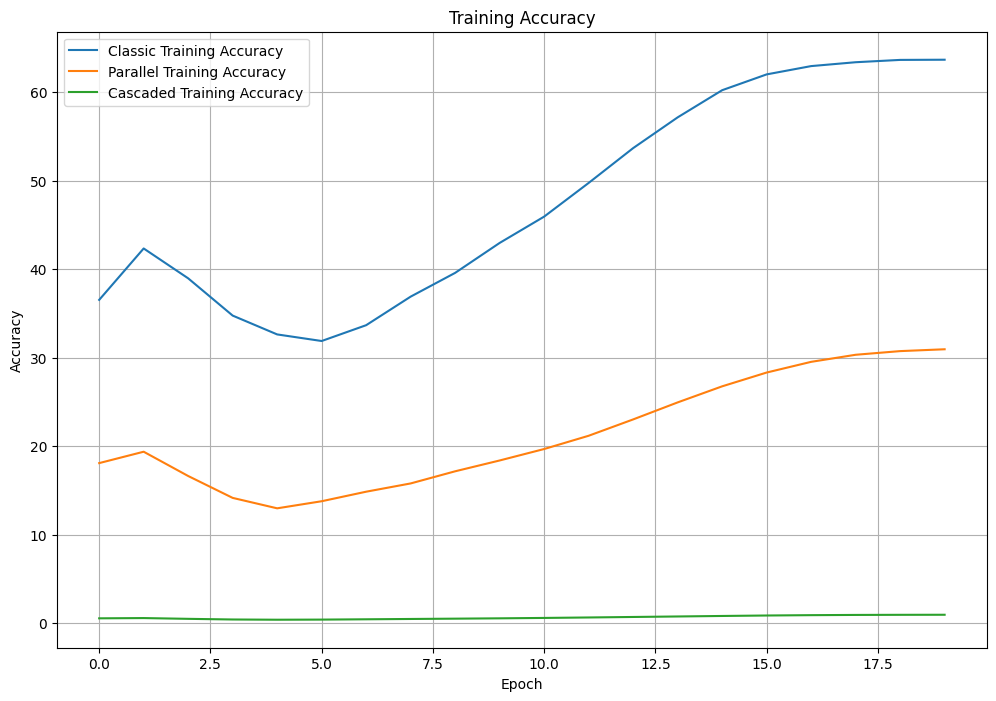

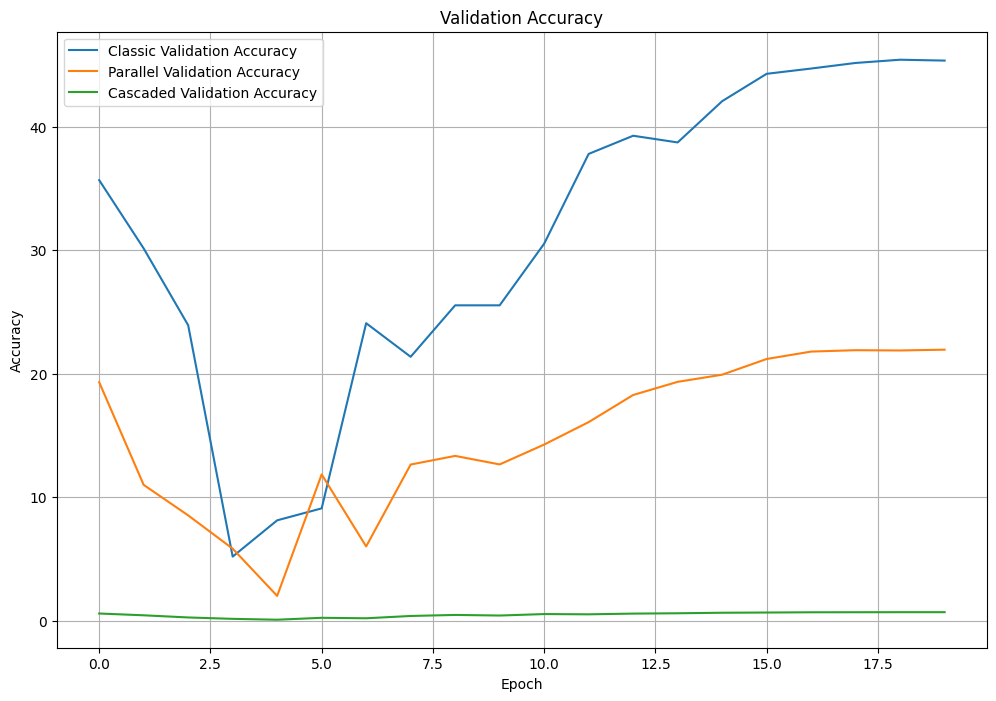

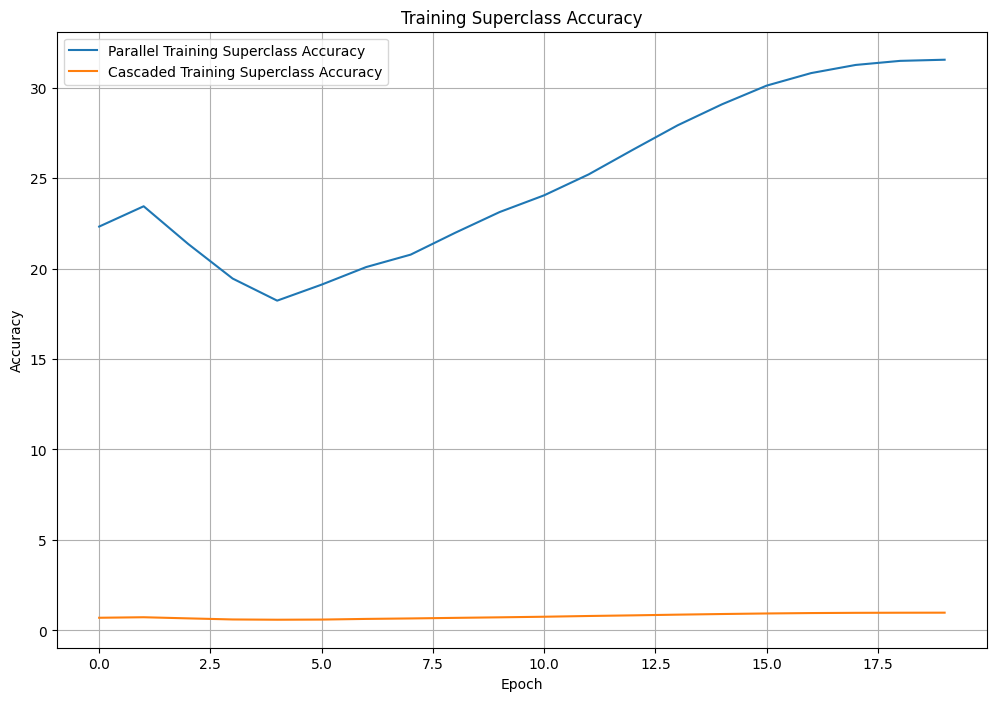

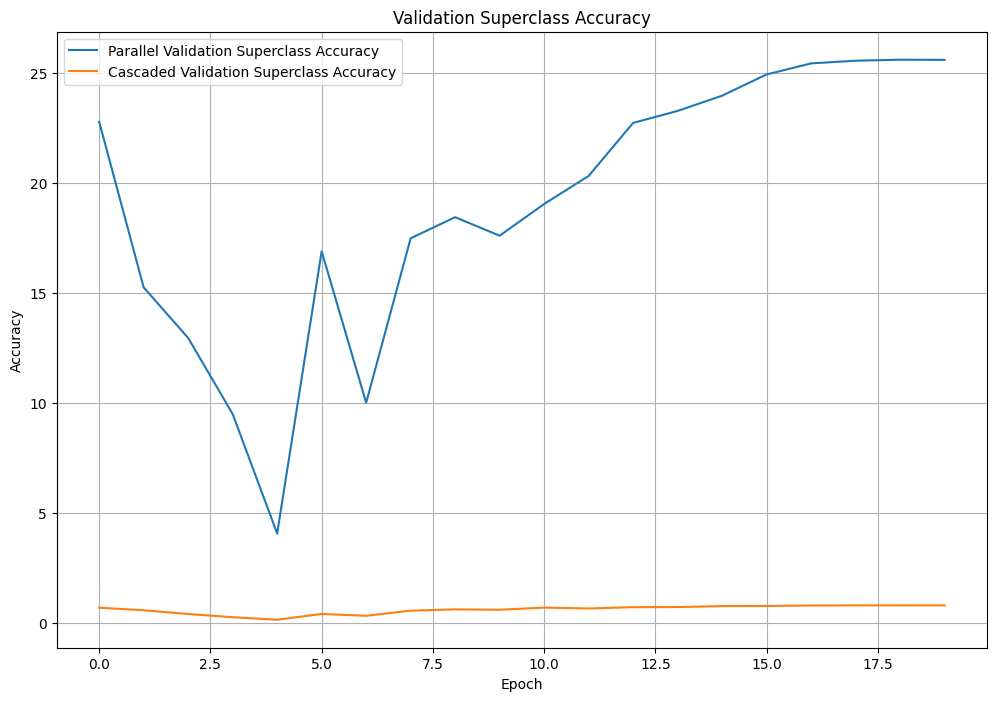

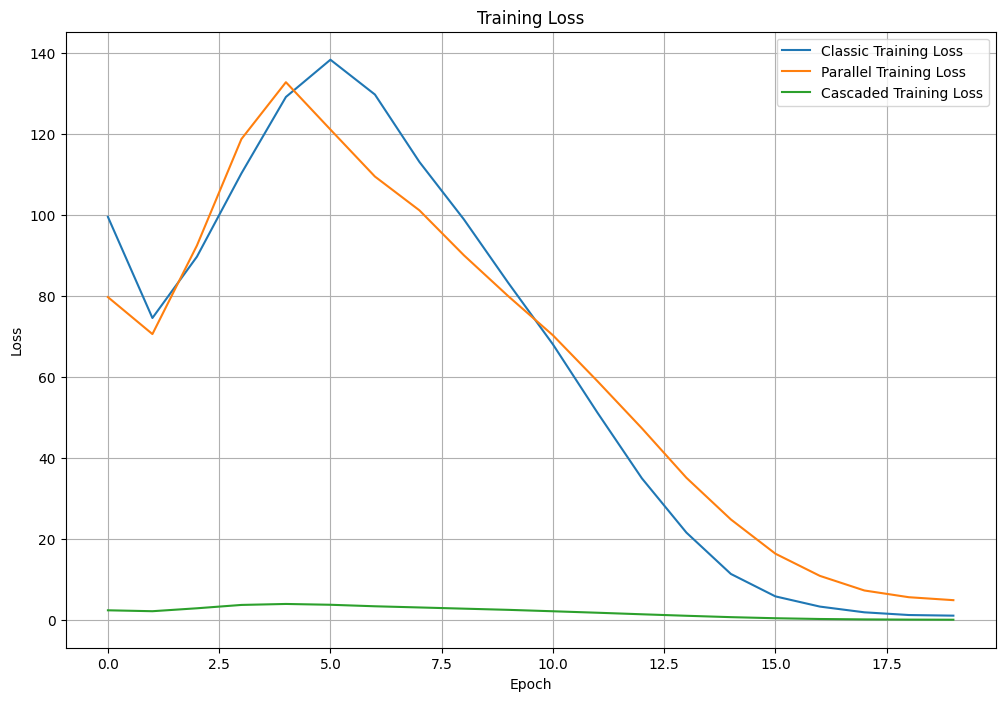

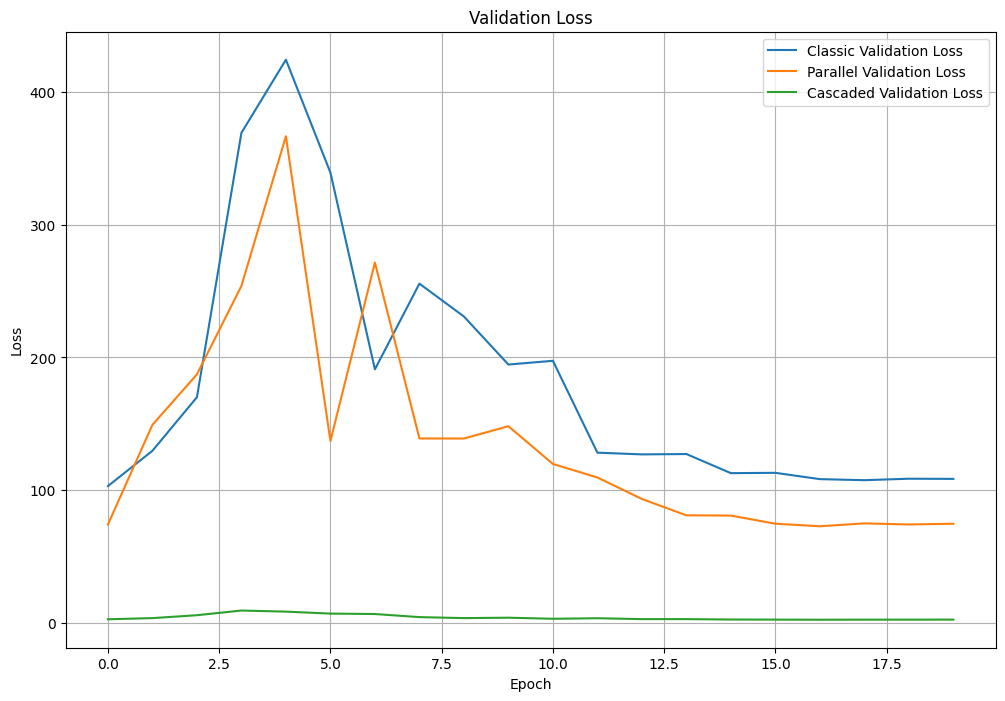

In [33]:
import os
import matplotlib.pyplot as plt

# Assuming you have these history dictionaries from your training sessions
# Each dictionary should contain lists like 'train_acc', 'val_acc', 'train_loss', 'val_loss'
# Example:
# classic_history = {'train_acc': [...], 'val_acc': [...], 'train_loss': [...], 'val_loss': [...]}
# hierarchic_history = {'train_acc': [...], 'val_acc': [...], 'train_loss': [...], 'val_loss': [...]}
# global_history = {'train_acc': [...], 'val_acc': [...], 'train_loss': [...], 'val_loss': [...]}
# parallel_history = {'train_acc': [...], 'val_acc': [...], 'train_loss': [...], 'val_loss': [...]}
# cascaded_history = {'train_acc': [...], 'val_acc': [...], 'train_loss': [...], 'val_loss': [...]}

# List of histories and labels for the plot
histories = [
    ('Classic', classic_history),
    # ('Hierarchic', hierarchic_history),
    ('Parallel', parallel_history),
    ('Cascaded', cascaded_history)
]

# Function to create a folder and save the plot
def save_plot(history_key, title, ylabel, save_path):
    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Plot the metric for each model
    plt.figure(figsize=(12, 8))
    for label, history in histories:
      if history_key in history:
        plt.plot(history[history_key], label=f'{label} {title}')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.grid(True)

    # Save the plot to the specified path
    plt.savefig(save_path)

    # Optionally, show the plot (you can comment this out if you don't want to display it)
    plt.show()

# Define the base directory where you want to save the plots
base_dir = BASE_DIR

# Save plots for each metric
save_plot('train_acc', 'Training Accuracy', 'Accuracy', os.path.join(base_dir, 'training_accuracy.png'))
save_plot('val_acc', 'Validation Accuracy', 'Accuracy', os.path.join(base_dir, 'validation_accuracy.png'))
save_plot('train_acc_superclass', 'Training Superclass Accuracy', 'Accuracy', os.path.join(base_dir, 'training_accuracy_superclass.png'))
save_plot('val_acc_superclass', 'Validation Superclass Accuracy', 'Accuracy', os.path.join(base_dir, 'validation_accuracy_superclass.png'))
save_plot('train_loss', 'Training Loss', 'Loss', os.path.join(base_dir, 'training_loss.png'))
save_plot('val_loss', 'Validation Loss', 'Loss', os.path.join(base_dir, 'validation_loss.png'))

In [ ]:
from google.colab import runtime
runtime.unassign()